In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import time 
import datetime
import statsmodels.api as sm
import pandas_datareader.data as web
import statsmodels.api as sm

In [2]:
def initDate(df):
    data=df
    data.set_index('Dates',drop=True,inplace=True)
    return data

In [3]:
def initTime(df):
    #Set the date index
    data=df
    data.set_index('Dates',drop=True,inplace=True)
    #Localize the HK time zone
    data.index=pd.to_datetime(data.index).tz_localize('Hongkong') #UTC-5
    #Convert the HK time zone to US to account for day light saving
    data.index=pd.to_datetime(data.index).tz_convert('US/Eastern') #UTC-5
    data['date']=data.index.date
    return data



In [4]:
def fm_summary(p):#Summary Statistics Function
    t=pd.Series((v for v in p ))
    s = t.describe().T
    s['Up Mean']=p[p>0].mean()
    s['Down Mean']=p[p<0].mean()
    s['Up Median']=p[p>0].median()
    s['Down Median']=p[p<0].median()
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    s['Up']=t[t>0].count()
    s['Down']=t[t<0].count()
    s['breakeven']=t[t==0].count()
    s['Up(%)']=t[t>0].count()/s['count']
    s['Down(%)']=t[t<0].count()/s['count']
    return s[['count','mean','Up','Down','breakeven','Up Mean','Down Mean','Up Median','Down Median','Up(%)','Down(%)']].T



In [5]:
dailyf=pd.read_excel("DAILYVIXDATA.xlsx","VVIXDAILY")
dailyf2=pd.read_excel("DAILYVIXDATA.xlsx","DAILYVIXETF")
dailyf3=pd.read_excel("DAILYVIXDATA.xlsx","UX1UX2DAILY")
df1=pd.read_excel("UXVIX.xlsx","UX1")
df2=pd.read_excel("UXVIX.xlsx","UX2")

In [613]:
VVIX=dailyf.copy()#copy aja
ETF=dailyf2.copy()
UX12daily=dailyf3.copy()
UX1=df1.copy()
UX2=df2.copy()

In [614]:
list2=[UX1,UX2]#update date
for itm in list2:
    itm=initTime(itm)
VVIX=initDate(VVIX)
VVIX.index=pd.to_datetime(VVIX.index).tz_localize('US/Eastern') 
ETF=initDate(ETF)
ETF.index=pd.to_datetime(ETF.index).tz_localize('US/Eastern') 
UX12daily=initDate(UX12daily)
UX12daily.index=pd.to_datetime(UX12daily.index).tz_localize('US/Eastern') 

In [615]:
UX1test=UX1.between_time('15:55','16:15')
UX2test=UX2.between_time('15:55','16:15')

In [616]:
VVIX1=VVIX[['VVIX OPEN','VVIX HIGH','VVIX LAST','VVIX LOW','VVIX MA100']]
VIX1=VVIX[['VIX OPEN','VIX HIGH','VIX LAST','VIX LOW','VIX MA101']]
#SPLIT VVIX AND VIX

In [617]:
UX12daily['SpreadDT']=UX12daily['PX_LAST2']-UX12daily['PX_LAST']

In [618]:
UX12daily['SpreadDT-1']=UX12daily['SpreadDT'].shift(1)

### ETF 

In [619]:
ETF['FLOW%']=(ETF['FLOWTOTAL']-ETF['FLOWTOTAL'].shift(1))/ETF['FLOWTOTAL'].shift(1).abs()
ETF['NAVTOTAL%']=(ETF['NAVTOTAL']-ETF['NAVTOTAL'].shift(1))/ETF['NAVTOTAL'].shift(1).abs()
ETF['FLOW%T-1']=ETF['FLOW%'].shift(1)
ETF['NAVTOTAL%T-1']=ETF['NAVTOTAL%'].shift(1)

### VVIX

In [620]:
VVIX1['extreme']=VVIX1['VVIX LAST'].rolling(21).quantile(.9).mean()

## Contango

In [630]:
layer=pd.concat([UX1test['Close'],UX2test['Close']],axis=1,join='inner')
layer.columns=['Close1','Close2']
layer['Date']=spread.index.date
layer['Spread']=spread['Close2']-spread['Close1']
contango=layer.copy()#[spread['Spread']>0.15]


In [641]:
a=contango.at_time('15:55').set_index('Date')['Spread']
b=contango.at_time('16:00').set_index('Date')['Spread']
c=contango.at_time('16:05').set_index('Date')['Spread']
d=contango.at_time('16:14').set_index('Date')['Spread']
a.index=pd.to_datetime(a.index).tz_localize('US/Eastern')
b.index=pd.to_datetime(b.index).tz_localize('US/Eastern')
c.index=pd.to_datetime(c.index).tz_localize('US/Eastern')
d.index=pd.to_datetime(d.index).tz_localize('US/Eastern')
e=UX12daily['SpreadDT-1']
stat=pd.concat([a,d,e],axis=1,join='inner') #b,c
stat.columns=['15:55','16:14','SpreadDT-1'] #'16:00','16:05',
stat['Long1']=stat['16:14']-stat['15:55']
#stat['Long2']=stat['16:14']-stat['16:00']
#stat['Long3']=stat['16:14']-stat['16:05']
stat['Long1_ret']=(stat['16:14']-stat['15:55'])/stat['15:55'].abs()
#stat['actual_signal']=np.where(stat['Long'])

In [642]:
##VVIX and ETF combination
strategy=pd.concat([stat,ETF[['FLOW%','FLOW%T-1','NAVTOTAL%','NAVTOTAL%T-1']],],axis=1,join='inner')


In [643]:
strategy1=pd.concat([strategy,VVIX1[['VVIX HIGH','extreme']]],axis=1,join='inner')


In [558]:
#missing some 0 return for regression
#strategy1=strategy1.drop(strategy1.loc['2020-11-04':'2020-11-06'].index)

In [644]:
strategy1

,15:55,16:14,SpreadDT-1,Long1,Long1_ret,FLOW%,FLOW%T-1,NAVTOTAL%,NAVTOTAL%T-1,VVIX HIGH,extreme
2020-05-15 00:00:00-04:00,0.65,0.55,0.550,-0.10,-0.153846,0.637975,-1.951717,-0.005073,-0.065634,141.31,134.047798
2020-05-18 00:00:00-04:00,1.30,1.20,0.600,-0.10,-0.076923,0.741861,0.637975,-0.089057,-0.005073,128.38,134.047798
2020-05-19 00:00:00-04:00,0.85,1.32,1.175,0.47,0.552941,12.944243,0.741861,0.066086,-0.089057,126.26,134.047798
2020-05-21 00:00:00-04:00,0.56,0.55,1.665,-0.01,-0.017857,7.310890,-0.867804,0.042098,-0.074028,123.63,134.047798
2020-05-22 00:00:00-04:00,0.54,0.70,0.600,0.16,0.296296,-1.783796,7.310890,-0.020711,0.042098,121.67,134.047798
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,1.29,1.42,2.465,0.13,0.100775,8.561268,-1.320891,-0.008515,0.020993,117.46,134.047798
2020-11-20 00:00:00-05:00,1.47,1.40,1.450,-0.07,-0.047619,-0.833452,8.561268,-0.001335,-0.008515,113.99,134.047798
2020-11-23 00:00:00-05:00,1.61,1.57,1.450,-0.04,-0.024845,-0.182345,-0.833452,-0.006095,-0.001335,114.09,134.047798
2020-11-24 00:00:00-05:00,1.89,1.86,1.625,-0.03,-0.015873,4.186265,-0.182345,-0.007769,-0.006095,109.30,134.047798


In [645]:
strategy1.index.dtype

datetime64[ns, US/Eastern]

In [796]:
Y=strategy1['Long1_ret']
X=sm.add_constant(strategy1[['FLOW%T-1','NAVTOTAL%T-1']])
model=sm.OLS(Y,X)
model.fit().summary()

MissingDataError: exog contains inf or nans

# Strategy

### Strategy Optimization

In [164]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data

In [324]:
#Initialize model set hyperparameter values
model=XGBClassifier(max_depth=2,n_estimators=30)

In [ ]:
#Initialzie KFold paremeters


## Backtesting

In [704]:
import pyfolio as pf
import empyrical as ep
import warnings
warnings.filterwarnings('ignore')

In [648]:
#(live_start_date='2018-01-01')
import pyfolio as pf


In [791]:
pf.create_full_tear_sheet(strategy1['Long1_ret'],benchmark_rets=strategy1['Long1'])

Entire data start date: 2020-05-18
Entire data end date: 2020-11-25
Backtest months: 6


,Backtest
Annual return,-22.9%
Cumulative returns,-12.4%
Annual volatility,700.9%
Sharpe ratio,1.25
Calmar ratio,-0.01
Stability,NaN
Max drawdown,-1737.1%
Omega ratio,1.45
Sortino ratio,1.85
Skew,-0.20


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

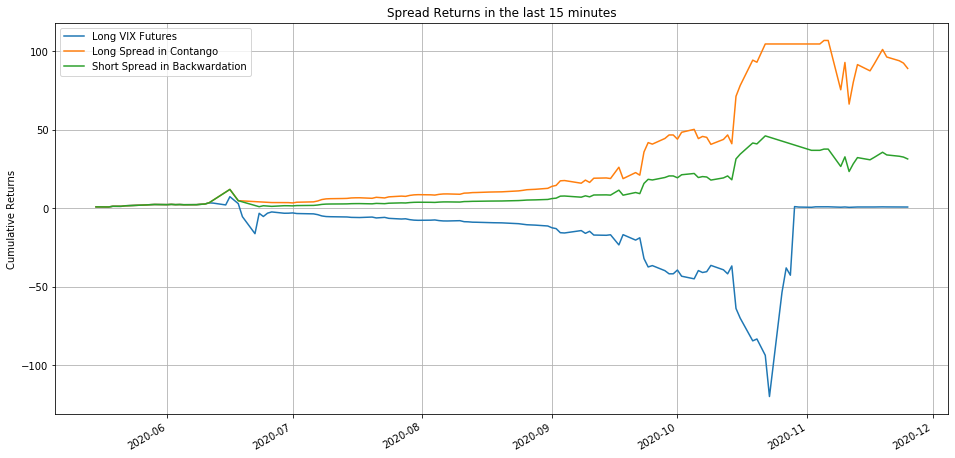

In [795]:
plt.figure(figsize=(16,8)) 
(strategy1['Long1_ret']+1).cumprod().plot(label='Long VIX Futures')
(strategy1[strategy1['SpreadDT-1']>0.1]['Long1_ret']+1).cumprod().plot(label='Long Spread in Contango')
(strategy1[-strategy1['SpreadDT-1']<0.1]['Long1_ret']+1).cumprod().plot(label='Short Spread in Backwardation')
plt.title('Spread Returns in the last 15 minutes')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.legend()
plt.show()

In [747]:
def initBacktest(data,name='Long1_ret'): 
    dummy=pd.DataFrame(0,index=pd.bdate_range('2020-05-15','2020-11-25').tz_localize('US/Eastern'),columns=['A'])
    tes2=pd.concat([dummy,data],axis=1)
    tes2=tes2.fillna(0)
    return tes2[name]